In [1]:
from src.utils import *
from src.models import *
from src.eval import *
from src.datasets import *
from src.visualize import *
import pytorch_lightning as pl
import matplotlib.pyplot as plt

%matplotlib inline


2023-11-26 20:27:06.943563: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from src.utils import *

In [3]:
import numpy as np
import pandas as pd

In [4]:
dataset=ImageSegmentationDataset(['/wclustre/nova/users/rafaelma/dataset/trimmed_FD_nominal_FHC_nonswap.999_of_2000.h5'])

Loaded 118 images.


/wclustre/nova/users/rafaelma/python385/lib/python3.8/site-packages/transformers/models/maskformer/image_processing_maskformer.py:419: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [5]:
ckpt_path=obtener_ultimo_ckpt_ruta(carpeta_raiz='./tb_logs/Mask2FormerNova_tunedv2_ag')
print(ckpt_path)
segmenter=Mask2FormerNovaTuned.load_from_checkpoint(ckpt_path,num_files=None)
#segmenter=Mask2FormerNova.load_from_checkpoint(ckpt_path,dataset_path='/wclustre/nova/users/rafaelma/dataset/',num_files=None)
#segmenter=Mask2FormerNova(dataset_path='/wclustre/nova/users/rafaelma/dataset/',num_files=None)

./tb_logs/Mask2FormerNova_tunedv2_ag/version_3/checkpoints/epoch=29-step=35760.ckpt


Some weights of the model checkpoint at facebook/mask2former-swin-tiny-coco-instance were not used when initializing Mask2FormerForUniversalSegmentation: ['model.pixel_level_module.encoder.encoder.layers.2.blocks.3.output.dense.bias', 'model.transformer_module.decoder.layers.6.cross_attn.in_proj_bias', 'model.transformer_module.decoder.layers.7.self_attn_layer_norm.weight', 'model.transformer_module.decoder.layers.4.cross_attn.out_proj.bias', 'model.pixel_level_module.encoder.encoder.layers.1.blocks.1.intermediate.dense.bias', 'model.transformer_module.decoder.layers.8.self_attn.k_proj.bias', 'model.transformer_module.decoder.layers.3.fc1.weight', 'model.transformer_module.decoder.layers.7.cross_attn.in_proj_weight', 'model.pixel_level_module.decoder.encoder.layers.2.final_layer_norm.bias', 'model.transformer_module.decoder.layers.5.self_attn.q_proj.weight', 'model.transformer_module.decoder.layers.2.cross_attn.out_proj.bias', 'model.pixel_level_module.encoder.encoder.layers.0.blocks.1

In [6]:

def convertir_a_mascaras_binarias(mascara_original):
    """
    Convierte una máscara de segmentación expresada como una matriz donde los valores desde 0 en adelante identifican los
    píxeles que corresponden a una instancia y el valor -1 significa que no hay nada, en una lista de máscaras binarias con
    valores 0 y 1 para cada instancia en la máscara original.

    Args:
        mascara_original (numpy.ndarray): La matriz de máscara original.

    Returns:
        list: Una lista de máscaras binarias, donde cada máscara corresponde a una instancia identificada en la máscara original.
    """
    # Encuentra todos los valores ImageSegmentationDataset(files)únicos en la máscara original que no sean -1
    valores_instancia = torch.unique(mascara_original[mascara_original != -1])

    # Inicializa una lista de máscaras binarias
    mascaras_binarias = []

    # Itera a través de los valores de instancia y crea máscaras binarias
    for valor in valores_instancia:
        mascara_binaria = (mascara_original == valor).int()
        mascaras_binarias.append(mascara_binaria)

    return torch.stack(mascaras_binarias, dim=0)



imagen condicion  torch.Size([85, 80, 3])
[] []


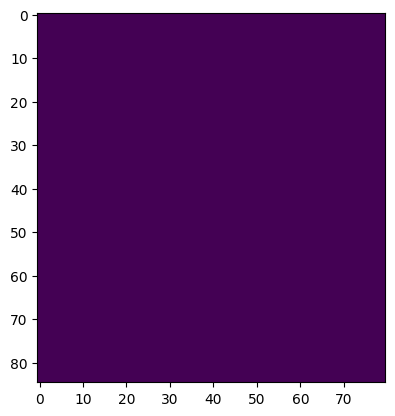

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


imagen condicion  torch.Size([85, 80, 3])
[] []


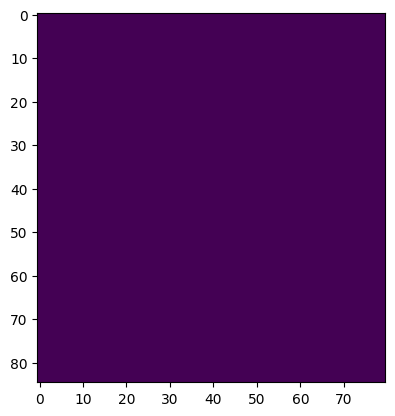

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


imagen condicion  torch.Size([85, 80, 3])
[1] [40]


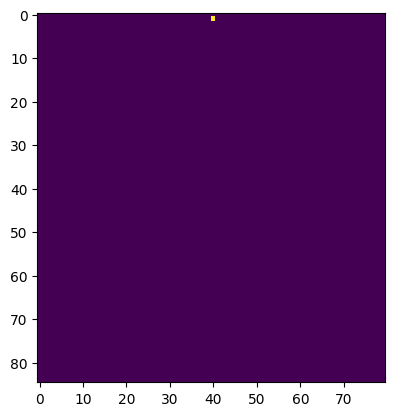

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


imagen condicion  torch.Size([85, 80, 3])
[] []


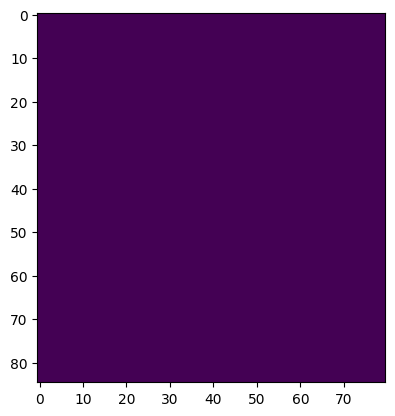

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


imagen condicion  torch.Size([85, 80, 3])
[] []


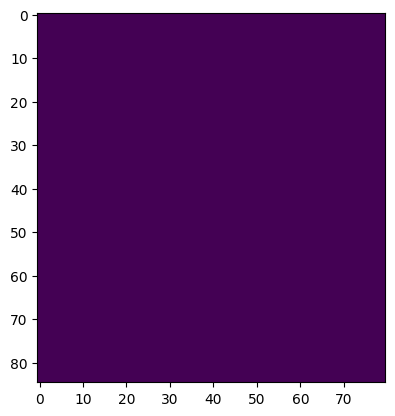

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


imagen condicion  torch.Size([85, 80, 3])
[] []


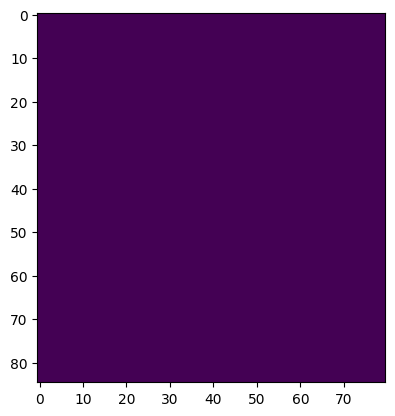

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


imagen condicion  torch.Size([85, 80, 3])
[] []


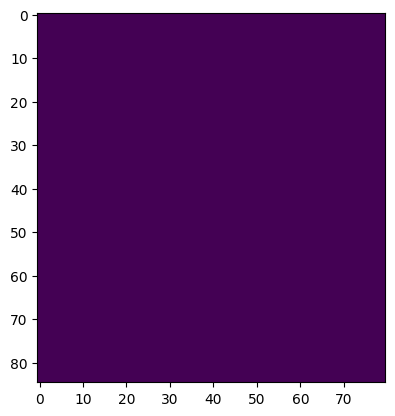

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


imagen condicion  torch.Size([85, 80, 3])
[] []


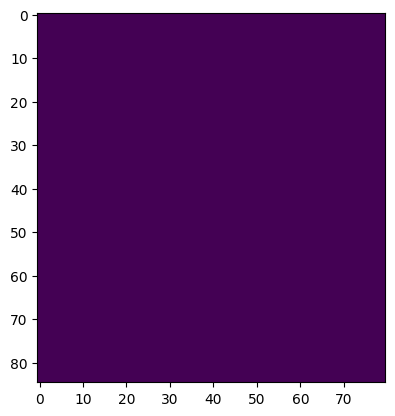

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


imagen condicion  torch.Size([85, 80, 3])
[ 0 31] [36  1]


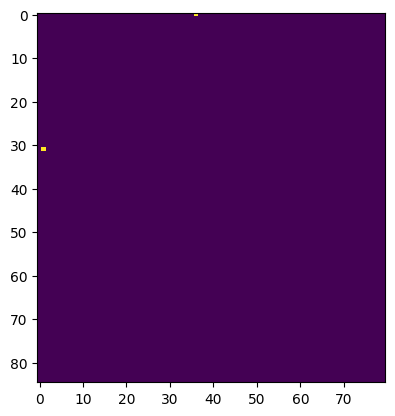

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


imagen condicion  torch.Size([85, 80, 3])
[0] [30]


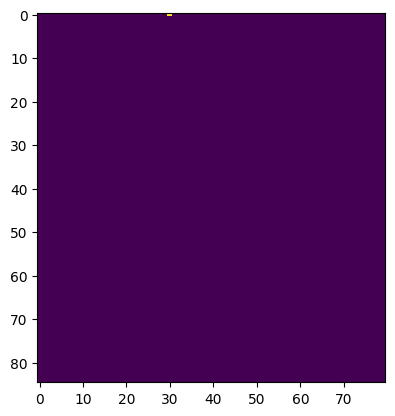

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [10]:
def reverse_subsample(mask, bbox=None, image=None):
    
    # Invertir la reducción de la máscara
    mask = mask.repeat(3,axis=0).repeat(3,axis=1)

    # Invertir la reducción de la imagen
    if image is not None:
        image =image.repeat(3,axis=0).repeat(3,axis=1)

    # Invertir la reducción de las cajas delimitadoras (bbox)
    if bbox is not None:
        bbox = bbox * 3
        bbox = np.asarray(list(map(lambda x: [x[0], x[1], x[2] - 0.5, x[3] - 0.5], bbox)))

    return mask, bbox, image
def subsample(mask, bbox=None, image=None):
    rows, cols, _ = mask.shape
    mask = mask.reshape(rows//3,3,cols//3,3,-1)
    mask = mask.any(axis=(1,3))

    if image is not None:
        image = image.reshape(rows//3,3,cols//3,3,-1)
        image = image.sum(axis=(1,3))/9

    if bbox is not None:
        bbox = bbox/3
        bbox = np.asarray(list(map(lambda x: [int(x[0]), int(x[1]), int(x[2]+0.5), int(x[3]+0.5)], bbox)))

    return mask, bbox, image

def post_process_nova(outputs_model,images):
    def dist(r,c,mask):
        row,col = np.where(mask>0)
        return min( map(lambda pt: np.sqrt((pt[0]-r)**2 + (pt[1]-c)**2), zip(row,col)) )
        
    outputs_post_process = post_process_instance_segmentation(outputs_model,target_sizes=[[255,240]]*60,threshold=0.5,return_binary_maps=False)
    outputs_post_process_nova=[]
    for idx,output in enumerate(outputs_post_process):
        output['instance_maps']=np.array(torch.stack(output['instance_maps'], dim=2))
        # Suppress Background
        #output['segmentation'][images[idx][1,:,:] == 0] = -1
        output['instance_maps'][images[idx][1,:,:] == 0] = np.zeros(output['instance_maps'].shape[2])
        
        # Downsample to hit level
        output['instance_maps'], _, image = subsample(output['instance_maps'], None, images[idx].permute(1, 2, 0))
        
        
        # Remove false positives
        bad = []
        for i,j in itertools.combinations(np.arange(output['instance_maps'].shape[2]),2):
            # Grab the pair of masks and compute area
            m1,m2  = output['instance_maps'][:,:,i], output['instance_maps'][:,:,j]
            a1,a2 = np.sum(m1), np.sum(m2)
            ac = np.sum(m1 & m2)
    
            # If cluster is direct subset of another and of sufficient size...
            if (ac>=a1-1 and ac>=0.1*a2) or (ac>=a2-1 and ac>=0.1*a1):
                if a1>=a2-1 and a2>=a1-1:
                    # Grab the largest score of identical clusters
                    if output['segments_info'][i]['score'] > output['segments_info'][j]['score']:
                        bad.append(j)
                    else:
                        bad.append(i)
                else:
                    # or the larger of two clusters
                    if a1 > a2:
                        bad.append(j)
                    else:
                        bad.append(i)
        
        # and delete them
        output['instance_maps'] = np.delete(output['instance_maps'],bad,axis=2)
        output['segments_info'] = np.delete(output['segments_info'],bad,axis=0)
        #r['rois']      = np.delete(r['rois'],bad,axis=0)
        #r['class_ids'] = np.delete(r['class_ids'],bad)
        #r['scores']    = np.delete(r['scores'],bad)

        # Identify unclustered hits

        print('imagen condicion ',image.shape)
        
        row,col = np.where((image[:,:,2] > 0) & ~output['instance_maps'].any(axis=2))
        print(row,col)
        plt.imshow((image[:,:,2] > 0) & ~output['instance_maps'].any(axis=2))
        plt.show()
        
        
        bbox=generar_cuadros_delimitadores(torch.tensor(output['instance_maps']).permute(2, 0, 1))
        
        
        for row,col in zip(row,col):
            cont=[]
            for n, [y1, x1, y2, x2] in enumerate(bbox):
                if row>=y1 and row<=y2 and col>=x1 and col<=x2:
                    cont.append(n)
            if len(cont)==1:
                
                
                if (dist(row,col,output['instance_maps'][:,:,cont[0]]) < 10 and output['segments_info'][cont[0]]['label_id'] in (1,7)) or \
                    dist(row,col,output['instance_maps'][:,:,cont[0]]) < 3.5:
                    
                    output['instance_maps'][row,col,cont[0]] = 1
            elif len(cont)>1:
                m=256
                for id in cont:
                    d = dist(row,col,output['instance_maps'][:,:,id])
                    if d < m:
                        m = d
                        i = id
                output['instance_maps'][row,col,i] = 1

        
        output['instance_maps'], _, _ = reverse_subsample(output['instance_maps'], None, None)
        
        output['instance_maps'] = np.transpose(output['instance_maps'], (2, 0, 1))
        
        outputs_post_process_nova.append(output)
    return outputs_post_process
    
for i in range(10):#range(len(dataset)):
    
    real=dataset[i]
    
    # Inference
    segmenter.model.eval()
    with torch.no_grad():
        outputs = segmenter.model(real["pixel_values"].unsqueeze(0))
    # you can pass them to processor for postprocessing
    #outputs = post_process_instance_segmentation(outputs,target_sizes=[[255,240]])
    outputs=post_process_nova(outputs,[real["pixel_values"]])
    
    #ids=torch.unique(outputs[0]['segmentation'])[1:].int().tolist()
    #print(ids)
    #masks=convertir_a_mascaras_binarias(outputs[0]['segmentation'])
    #print(masks.shape)
    masks=outputs[0]['instance_maps']
    label_ids = torch.tensor([dato['label_id'] for dato in outputs[0]['segments_info']])#[ids]
    scores = torch.tensor([dato['softmax'][dato['label_id']] for dato in outputs[0]['segments_info']])#[ids]
    masks=torch.tensor(masks)
    display_instances(
            real["pixel_values"], 
            generar_cuadros_delimitadores(masks),
            masks.permute(1, 2, 0), 
            label_ids,
            scores=scores,
            class_names=['Electron', 'Muon', 'Proton', 'Photon', 'Pion'],
            title='images/mask2former/ejemplo-'+str(i)+'.jpg',
            save=True)
    
    

In [ ]:
 
def generar_cuadros_delimitadores(mascaras_segmentacion):
    cuadros_delimitadores=[]
    for mascara in mascaras_segmentacion:
        
        # Obtener las coordenadas del cuadro delimitador
        
        coords = torch.nonzero(mascara)
        if coords.numel() > 0:  # Verificar si hay elementos en el tensor de coordenadas

            # Calcular los límites del cuadro delimitador
            y1 = coords[:, 0].min().item()
            x1 = coords[:, 1].min().item()
            y2 = coords[:, 0].max().item()
            x2 = coords[:, 1].max().item()

            # Agregar el cuadro delimitador a la lista
            cuadro_delimitador = (y1, x1, y2, x2)#, segments_info[int(i)]['label_id'])
            cuadros_delimitadores.append(cuadro_delimitador)
        else:
            cuadros_delimitadores.append((0, 0, 0, 0))
    return torch.tensor(cuadros_delimitadores)

generar_cuadros_delimitadores(masks)

In [ ]:
torch.tensor([[  0,  90,   2,  95],[  0,  93,  56, 149]]).shape

In [ ]:
for i in range(len(dataset)):
    
    real=dataset[i]
    display_instances(
            real["pixel_values"], 
            generar_cuadros_delimitadores(real['mask_labels']),
            real['mask_labels'].permute(1, 2, 0), 
            real['class_labels'], 
            ['Electron', 'Muon', 'Proton', 'Photon', 'Pion'],
            title='images/real/ejemplo-'+str(i)+'.jpg',
            save=False)
    
    